**Introduction**  

This notebook focuses on building an **Ordinary Least Squares (OLS) regression model** with a structured approach that includes **feature engineering, data cleaning, outlier detection, and Principal Component Analysis (PCA) for feature selection**.  

The notebooks begin with **data preprocessing**, handling missing values and transforming variables to improve model performance. **Outliers are detected and removed** using kNN detector provided by pyod to enhance data quality. Next, **PCA** is applied to reduce dimensionality and retain the most informative features. Finally, the refined dataset is used to fit an **OLS regression**, followed by diagnostic tests and residual analysis to evaluate its performance.  



# Libraries and Basic Functions

In [30]:
# Import libaries
!pip install -qq pyod
from pyod.models.knn import KNN   # kNN detector
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
import numpy as np
import pandas as pd
import kagglehub
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import boxcox
import scipy.stats as stats
from statsmodels.graphics.regressionplots import abline_plot
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline
from scipy.stats import kendalltau
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings

# Ignore any warnings
warnings.filterwarnings("ignore")

# Set pandas display options to show real numbers
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
def scatter_plot(target_var, df, num_cols, title):
  '''
  target_var (col): the target variable in df
  df: the dataframe you want to plot
  num_cols (int): define the number of columns per row
  title (str): the plot title
  '''
  # Get all columns except the target
  all_vars = [col for col in df.columns if col != target_var]

  # Determine the number of rows and columns for subplots dynamically
  num_plots = len(all_vars)
  num_rows = int(np.ceil(num_plots / num_cols))  # Calculate the required number of rows

  # Create subplots
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))
  fig.suptitle(title, fontsize=16)
  axes = axes.flatten()  # Flatten axes for easy iteration

  # Plot each variable against the target
  for plot_idx, var in enumerate(all_vars):
    sns.scatterplot(x=df[var], y=df[target_var], ax=axes[plot_idx])
    axes[plot_idx].set_title(f'{var} vs {target_var}')
    axes[plot_idx].set_xlabel(var)
    axes[plot_idx].set_ylabel(target_var)

  # Hide any unused subplots
  for j in range(plot_idx + 1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
  plt.show()

In [3]:
def plot_pairplot(df, hue_col=None, title="Pairplot"):
    """
    Plots a Seaborn pairplot with optional hue.

    Parameters:
    - df (DataFrame): The dataset to visualize.
    - hue_col (str, optional): Column name for hue (e.g., 'Outlier'). Defaults to None.
    - title (str): Title to print.
    """

    # Define variables for pairplot (exclude hue column if provided)
    vars_to_plot = [col for col in df.columns if col != hue_col] if hue_col else df.columns

    sns.pairplot(
        data=df,
        vars=vars_to_plot,
        diag_kind="kde",  # Use KDE for diagonal plots
        corner=True,  # Show only lower triangle of the pairplot
        hue=hue_col,  # Color by outlier status (if given)
        palette={0: "blue", 1: "red"} if hue_col else None,  # Apply color only if hue exists
        plot_kws={"alpha": 0.6, "s": 50},  # Transparency and size for scatter plots
        height=2.5  # Adjust height of each subplot
    )

    print(title)
    plt.show()

In [4]:
def boxplot(df, num_cols, title, fig_no):
  '''
  df: the dataframe you want to plot
  num_cols (int): define the number of columns per row
  title (str): the plot title
  fig_no (int)
  '''
  # Determine the number of rows and columns for subplots dynamically
  num_plots = len(df.columns)
  num_rows = int(np.ceil(num_plots / num_cols))  # Calculate required rows

  # Set up the figure
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
  fig.suptitle(title, fontsize=16)
  axes = axes.flatten()  # Flatten axes array for easy iteration

  # Create boxplots for each numerical column
  for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Fig.{fig_no}.{i+1} - {col}", fontsize=12)
    axes[i].set_ylabel('')  # Remove y-axis label for cleaner look

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
  plt.show()

# **1. Import Data**


In [5]:
# Download latest version
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

print("Path to dataset files:", path)

# Upload the file to Google Colab
uploaded = files. upload()

100%|██████████| 4.63k/4.63k [00:00<00:00, 7.52MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1


Saving Housing.csv to Housing.csv


## A. Load the dataset

In [6]:
# Read the file
df = pd.read_csv('Housing.csv')
df.head()

price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished

## B. Understand the dataset

In [7]:
# Check dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


In [8]:
# Convert numerical columns (int64) to float
df[df.select_dtypes(include=['int64']).columns] = df.select_dtypes(include=['int64']).astype(float)

# Convert object columns to string
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).astype("str")

# Verify the changes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    float64
 1   area              545 non-null    float64
 2   bedrooms          545 non-null    float64
 3   bathrooms         545 non-null    float64
 4   stories           545 non-null    float64
 5   mainroad          545 non-null    object 
 6   guestroom         545 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   545 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           545 non-null    float64
 11  prefarea          545 non-null    object 
 12  furnishingstatus  545 non-null    object 
dtypes: float64(6), object(7)
memory usage: 55.5+ KB
None


In [9]:
# Check for missing values
print(df.isnull().sum())

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [10]:
# Basic statistics
print(df.describe())

            price     area  bedrooms  bathrooms  stories  parking
count      545.00   545.00    545.00     545.00   545.00   545.00
mean   4766729.25  5150.54      2.97       1.29     1.81     0.69
std    1870439.62  2170.14      0.74       0.50     0.87     0.86
min    1750000.00  1650.00      1.00       1.00     1.00     0.00
25%    3430000.00  3600.00      2.00       1.00     1.00     0.00
50%    4340000.00  4600.00      3.00       1.00     2.00     0.00
75%    5740000.00  6360.00      3.00       2.00     2.00     1.00
max   13300000.00 16200.00      6.00       4.00     4.00     3.00


In [11]:
# Check uniqueness in categorical columns
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Unique values in {col}: {unique_values}")

Unique values in mainroad: ['yes' 'no']
Unique values in guestroom: ['no' 'yes']
Unique values in basement: ['no' 'yes']
Unique values in hotwaterheating: ['no' 'yes']
Unique values in airconditioning: ['yes' 'no']
Unique values in prefarea: ['yes' 'no']
Unique values in furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


## C. Feature Engineering

In [12]:
# Convert binary categorical variables ('yes' → 1, 'no' → 0)
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_columns] = df[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))

# Furnishing Status
furnishing_map = {'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}
df['furnishing_level'] = df['furnishingstatus'].map(furnishing_map)

In [13]:
# Feature Engineering
df.loc[:, 'price_per_area'] = df.loc[:, 'price'] / df.loc[:, 'area']
df.loc[:,'price_per_bedroom'] = df.loc[:,'price'] / df.loc[:,'bedrooms']
df.loc[:,'price_per_bathroom'] = df.loc[:,'price'] / df.loc[:,'bathrooms']
df.loc[:,'price_per_story'] = df.loc[:,'price'] / df.loc[:,'stories']
luxury_score = df['airconditioning'] + df['hotwaterheating'] + df['prefarea'] + df['furnishing_level'] + df['mainroad']
df.loc[:,'price_per_score'] = df.loc[:,'price'] / luxury_score

# Total room count (sum of bedrooms, bathrooms, basement, and guestroom)
total_room = df.loc[:, 'bedrooms'] + df.loc[:, 'bathrooms'] + df.loc[:, 'basement'] + df.loc[:, 'guestroom']
df.loc[:, 'price_per_room'] = df.price / total_room

# Drop redundant columns
df = df.drop(columns=['furnishingstatus'])
df.head()

price    area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0 13300000.00 7420.00      4.00       2.00     3.00         1          0   
1 12250000.00 8960.00      4.00       4.00     4.00         1          0   
2 12250000.00 9960.00      3.00       2.00     2.00         1          0   
3 12215000.00 7500.00      4.00       2.00     2.00         1          0   
4 11410000.00 7420.00      4.00       1.00     2.00         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1     2.00         1   
1         0                0                1     3.00         0   
2         1                0                0     2.00         1   
3         1                0                1     3.00         1   
4         1                0                1     2.00         0   

   furnishing_level  price_per_area  price_per_bedroom  price_per_bathroom  \
0                 2         1792.45         3325000.00          6650000.00   
1                 2         1367.19         3062500.00          3062500.00   
2                 1         1229.92         4083333.33          6125000.00   
3                 2         1628.67         3053750.00          6107500.00   
4                 2         1537.74         2852500.00         11410000.00   

   price_per_story  price_per_score  price_per_room  
0       4433333.33       2660000.00      2216666.67  
1       3062500.00       3062500.00      1531250.00  
2       6125000.00       4083333.33      2041666.67  
3       6107500.00       2443000.00      1745000.00  
4       5705000.00       2852500.00      1630000.00

## D. Data Vizualition

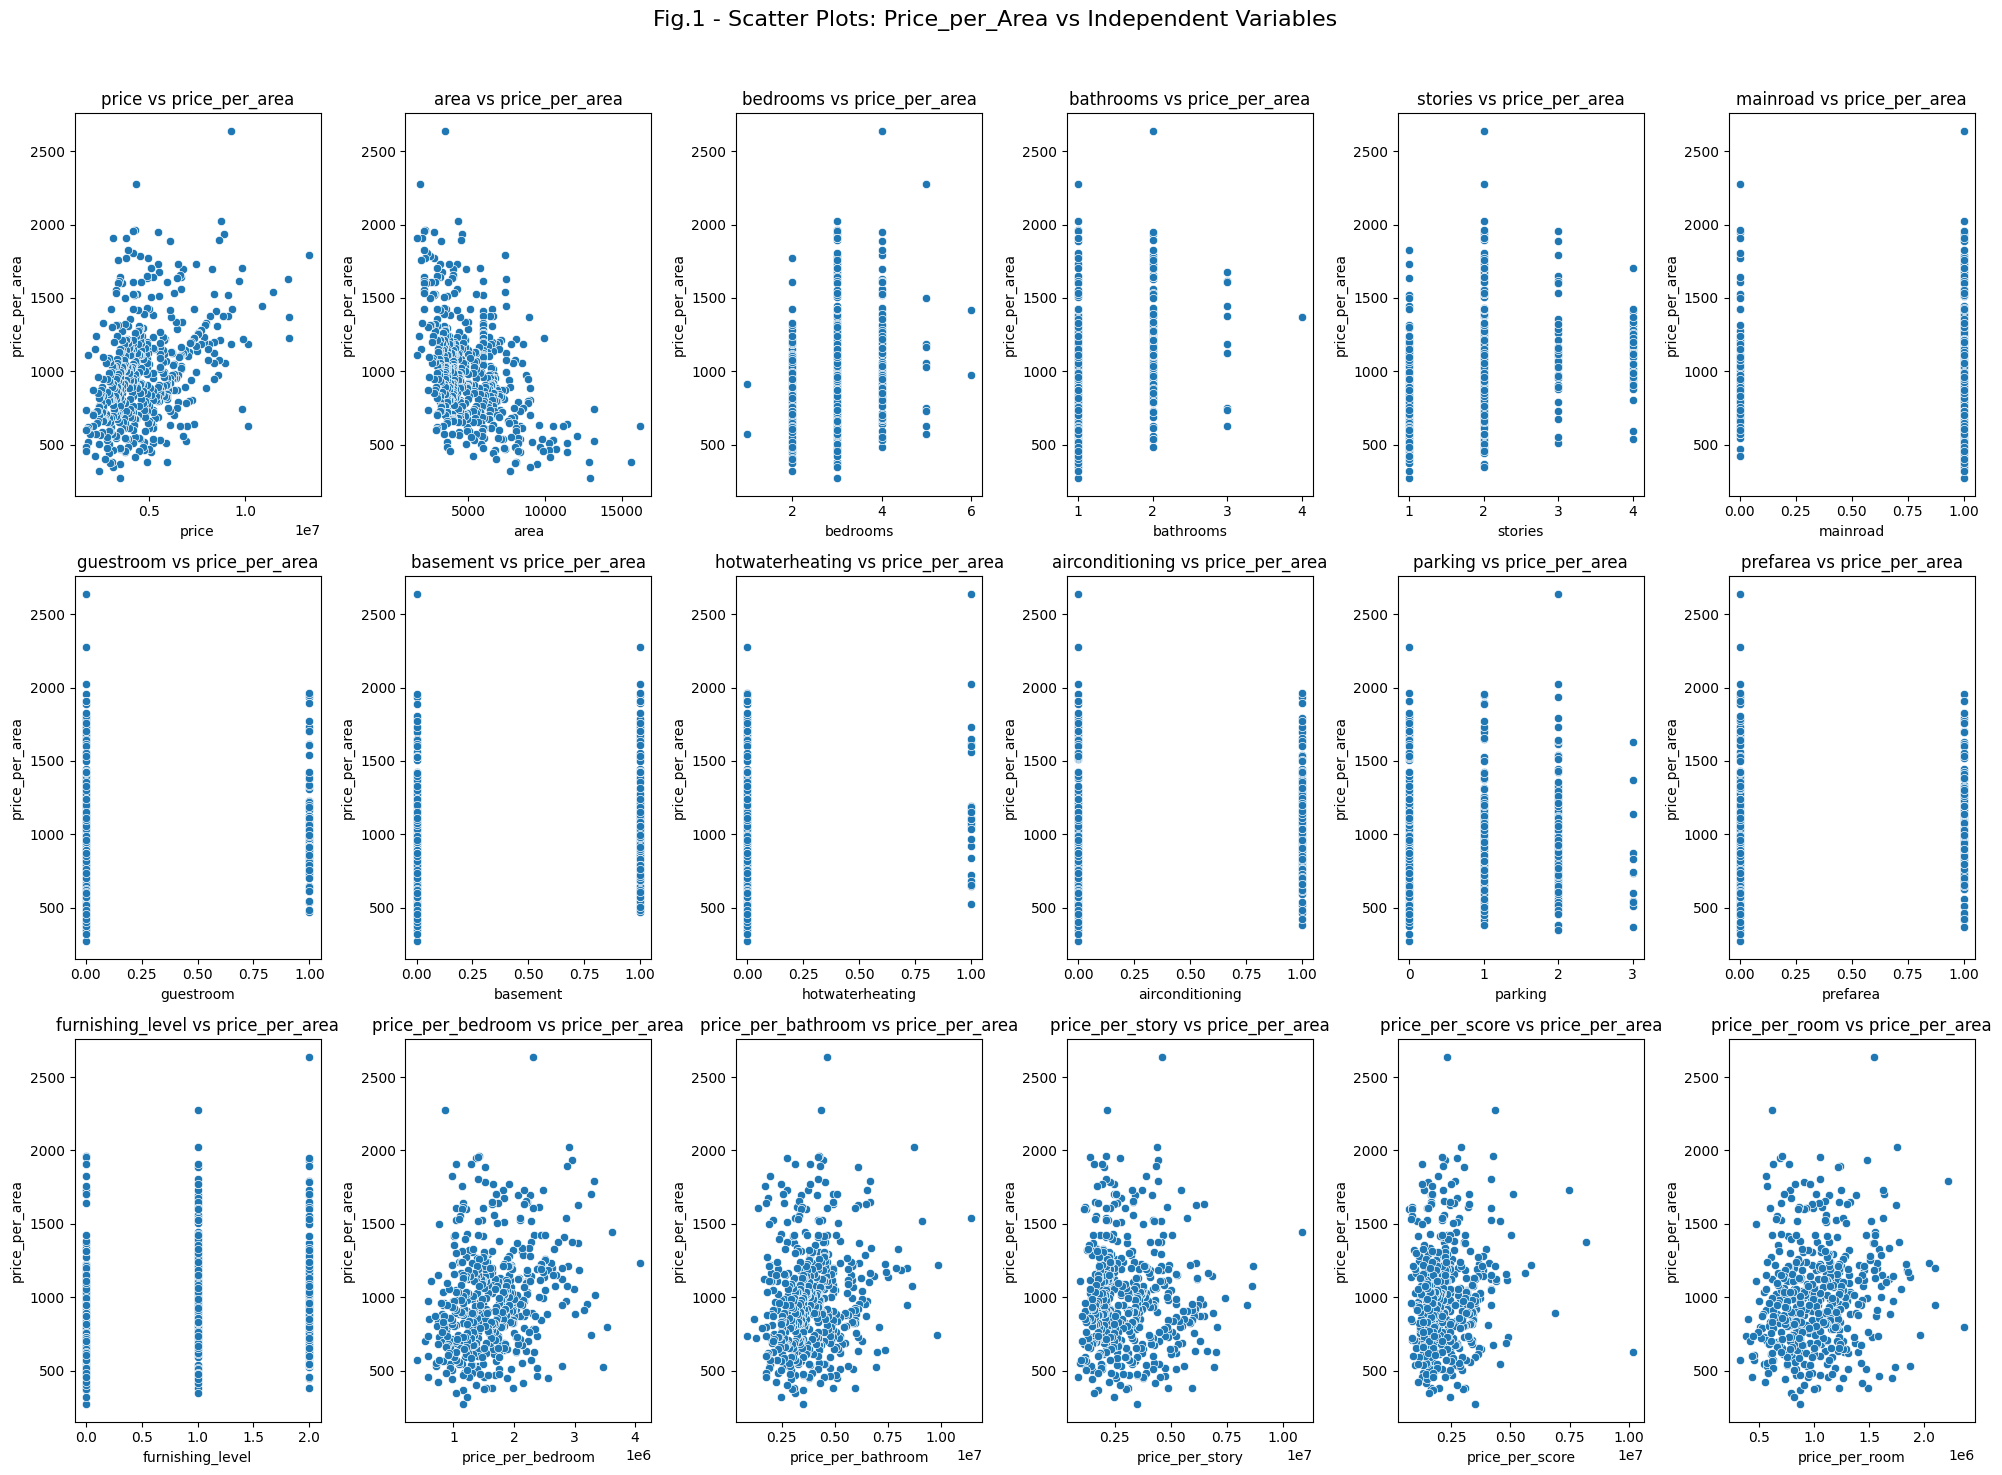

In [14]:
title = 'Fig.1 - Scatter Plots: Price_per_Area vs Independent Variables'
target_var = 'price_per_area'
num_cols = 6
scatter_plot(target_var, df, num_cols, title)

# **2. Data Processing**

## 2.A. Data Transformation

In [15]:
df.head()

price    area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0 13300000.00 7420.00      4.00       2.00     3.00         1          0   
1 12250000.00 8960.00      4.00       4.00     4.00         1          0   
2 12250000.00 9960.00      3.00       2.00     2.00         1          0   
3 12215000.00 7500.00      4.00       2.00     2.00         1          0   
4 11410000.00 7420.00      4.00       1.00     2.00         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1     2.00         1   
1         0                0                1     3.00         0   
2         1                0                0     2.00         1   
3         1                0                1     3.00         1   
4         1                0                1     2.00         0   

   furnishing_level  price_per_area  price_per_bedroom  price_per_bathroom  \
0                 2         1792.45         3325000.00          6650000.00   
1                 2         1367.19         3062500.00          3062500.00   
2                 1         1229.92         4083333.33          6125000.00   
3                 2         1628.67         3053750.00          6107500.00   
4                 2         1537.74         2852500.00         11410000.00   

   price_per_story  price_per_score  price_per_room  
0       4433333.33       2660000.00      2216666.67  
1       3062500.00       3062500.00      1531250.00  
2       6125000.00       4083333.33      2041666.67  
3       6107500.00       2443000.00      1745000.00  
4       5705000.00       2852500.00      1630000.00

In [16]:
# Columns to transform
columns= ['price','area','price_per_area','price_per_bedroom','price_per_bathroom','price_per_story','price_per_score','price_per_room']

# Create a new copy
df_transformed = df.copy()

# Square Root Transformation
df_transformed[columns] = np.log(df[columns])

# Replace inf with nan
df_transformed = df_transformed.replace([np.inf, -np.inf], np.nan)
df_cleaned = df_transformed.dropna()
df_cleaned

price  area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0    16.40  8.91      4.00       2.00     3.00         1          0         0   
1    16.32  9.10      4.00       4.00     4.00         1          0         0   
2    16.32  9.21      3.00       2.00     2.00         1          0         1   
3    16.32  8.92      4.00       2.00     2.00         1          0         1   
4    16.25  8.91      4.00       1.00     2.00         1          1         1   
..     ...   ...       ...        ...      ...       ...        ...       ...   
540  14.41  8.01      2.00       1.00     1.00         1          0         1   
541  14.38  7.78      3.00       1.00     1.00         0          0         0   
542  14.38  8.19      2.00       1.00     1.00         1          0         0   
543  14.38  7.98      3.00       1.00     1.00         0          0         0   
544  14.38  8.26      3.00       1.00     2.00         1          0         0   

     hotwaterheating  airconditioning  parking  prefarea  furnishing_level  \
0                  0                1     2.00         1                 2   
1                  0                1     3.00         0                 2   
2                  0                0     2.00         1                 1   
3                  0                1     3.00         1                 2   
4                  0                1     2.00         0                 2   
..               ...              ...      ...       ...               ...   
540                0                0     2.00         0                 0   
541                0                0     0.00         0                 1   
542                0                0     0.00         0                 0   
543                0                0     0.00         0                 2   
544                0                0     0.00         0                 0   

     price_per_area  price_per_bedroom  price_per_bathroom  price_per_story  \
0              7.49              15.02               15.71            15.30   
1              7.22              14.93               14.93            14.93   
2              7.11              15.22               15.63            15.63   
3              7.40              14.93               15.63            15.63   
4              7.34              14.86               16.25            15.56   
..              ...                ...                 ...              ...   
540            6.41              13.72               14.41            14.41   
541            6.60              13.29               14.38            14.38   
542            6.18              13.68               14.38            14.38   
543            6.40              13.28               14.38            14.38   
544            6.12              13.28               14.38            13.68   

     price_per_score  price_per_room  
0              14.79           14.61  
1              14.93           14.24  
2              15.22           14.53  
3              14.71           14.37  
4              14.86           14.30  
..               ...             ...  
540            14.41           13.03  
541            14.38           13.00  
542            14.38           13.28  
543            13.68           12.99  
544            14.38           12.99  

[518 rows x 19 columns]

Fig.2 - Pairplot of Variables


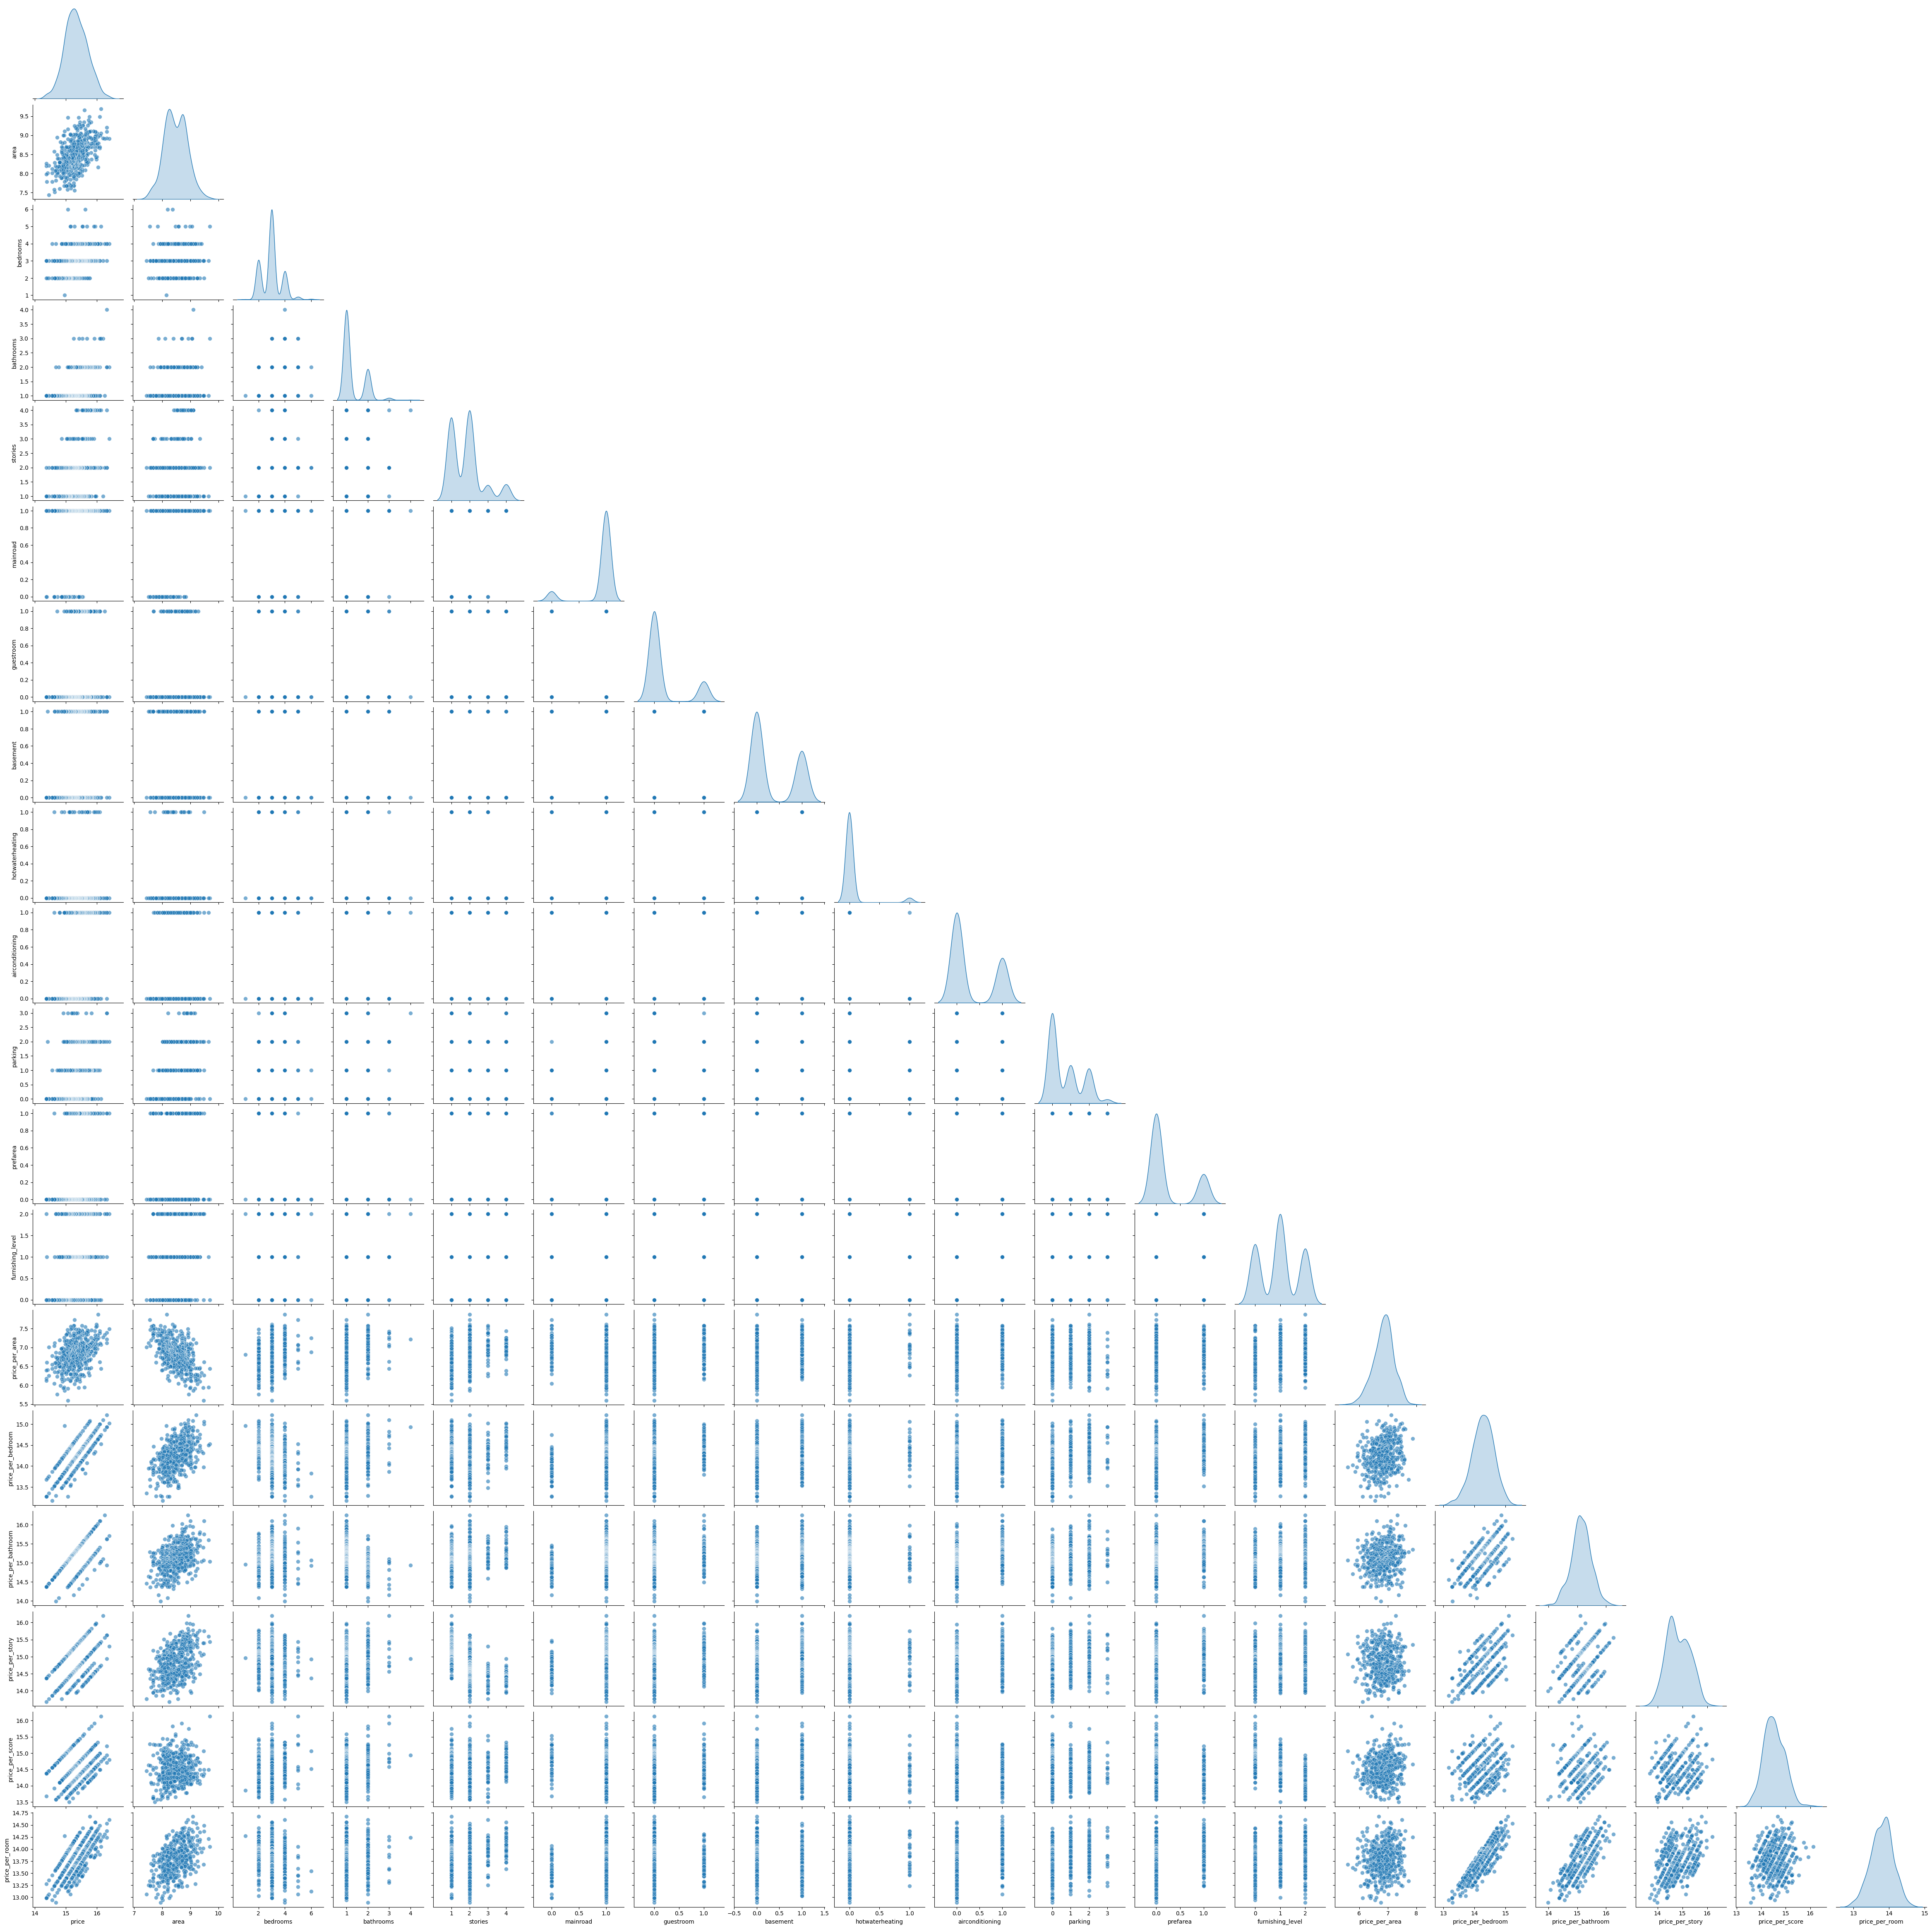

In [17]:
plot_pairplot(df_cleaned, hue_col=None, title = "Fig.2 - Pairplot of Variables")

## 2.B. Outlier Detection

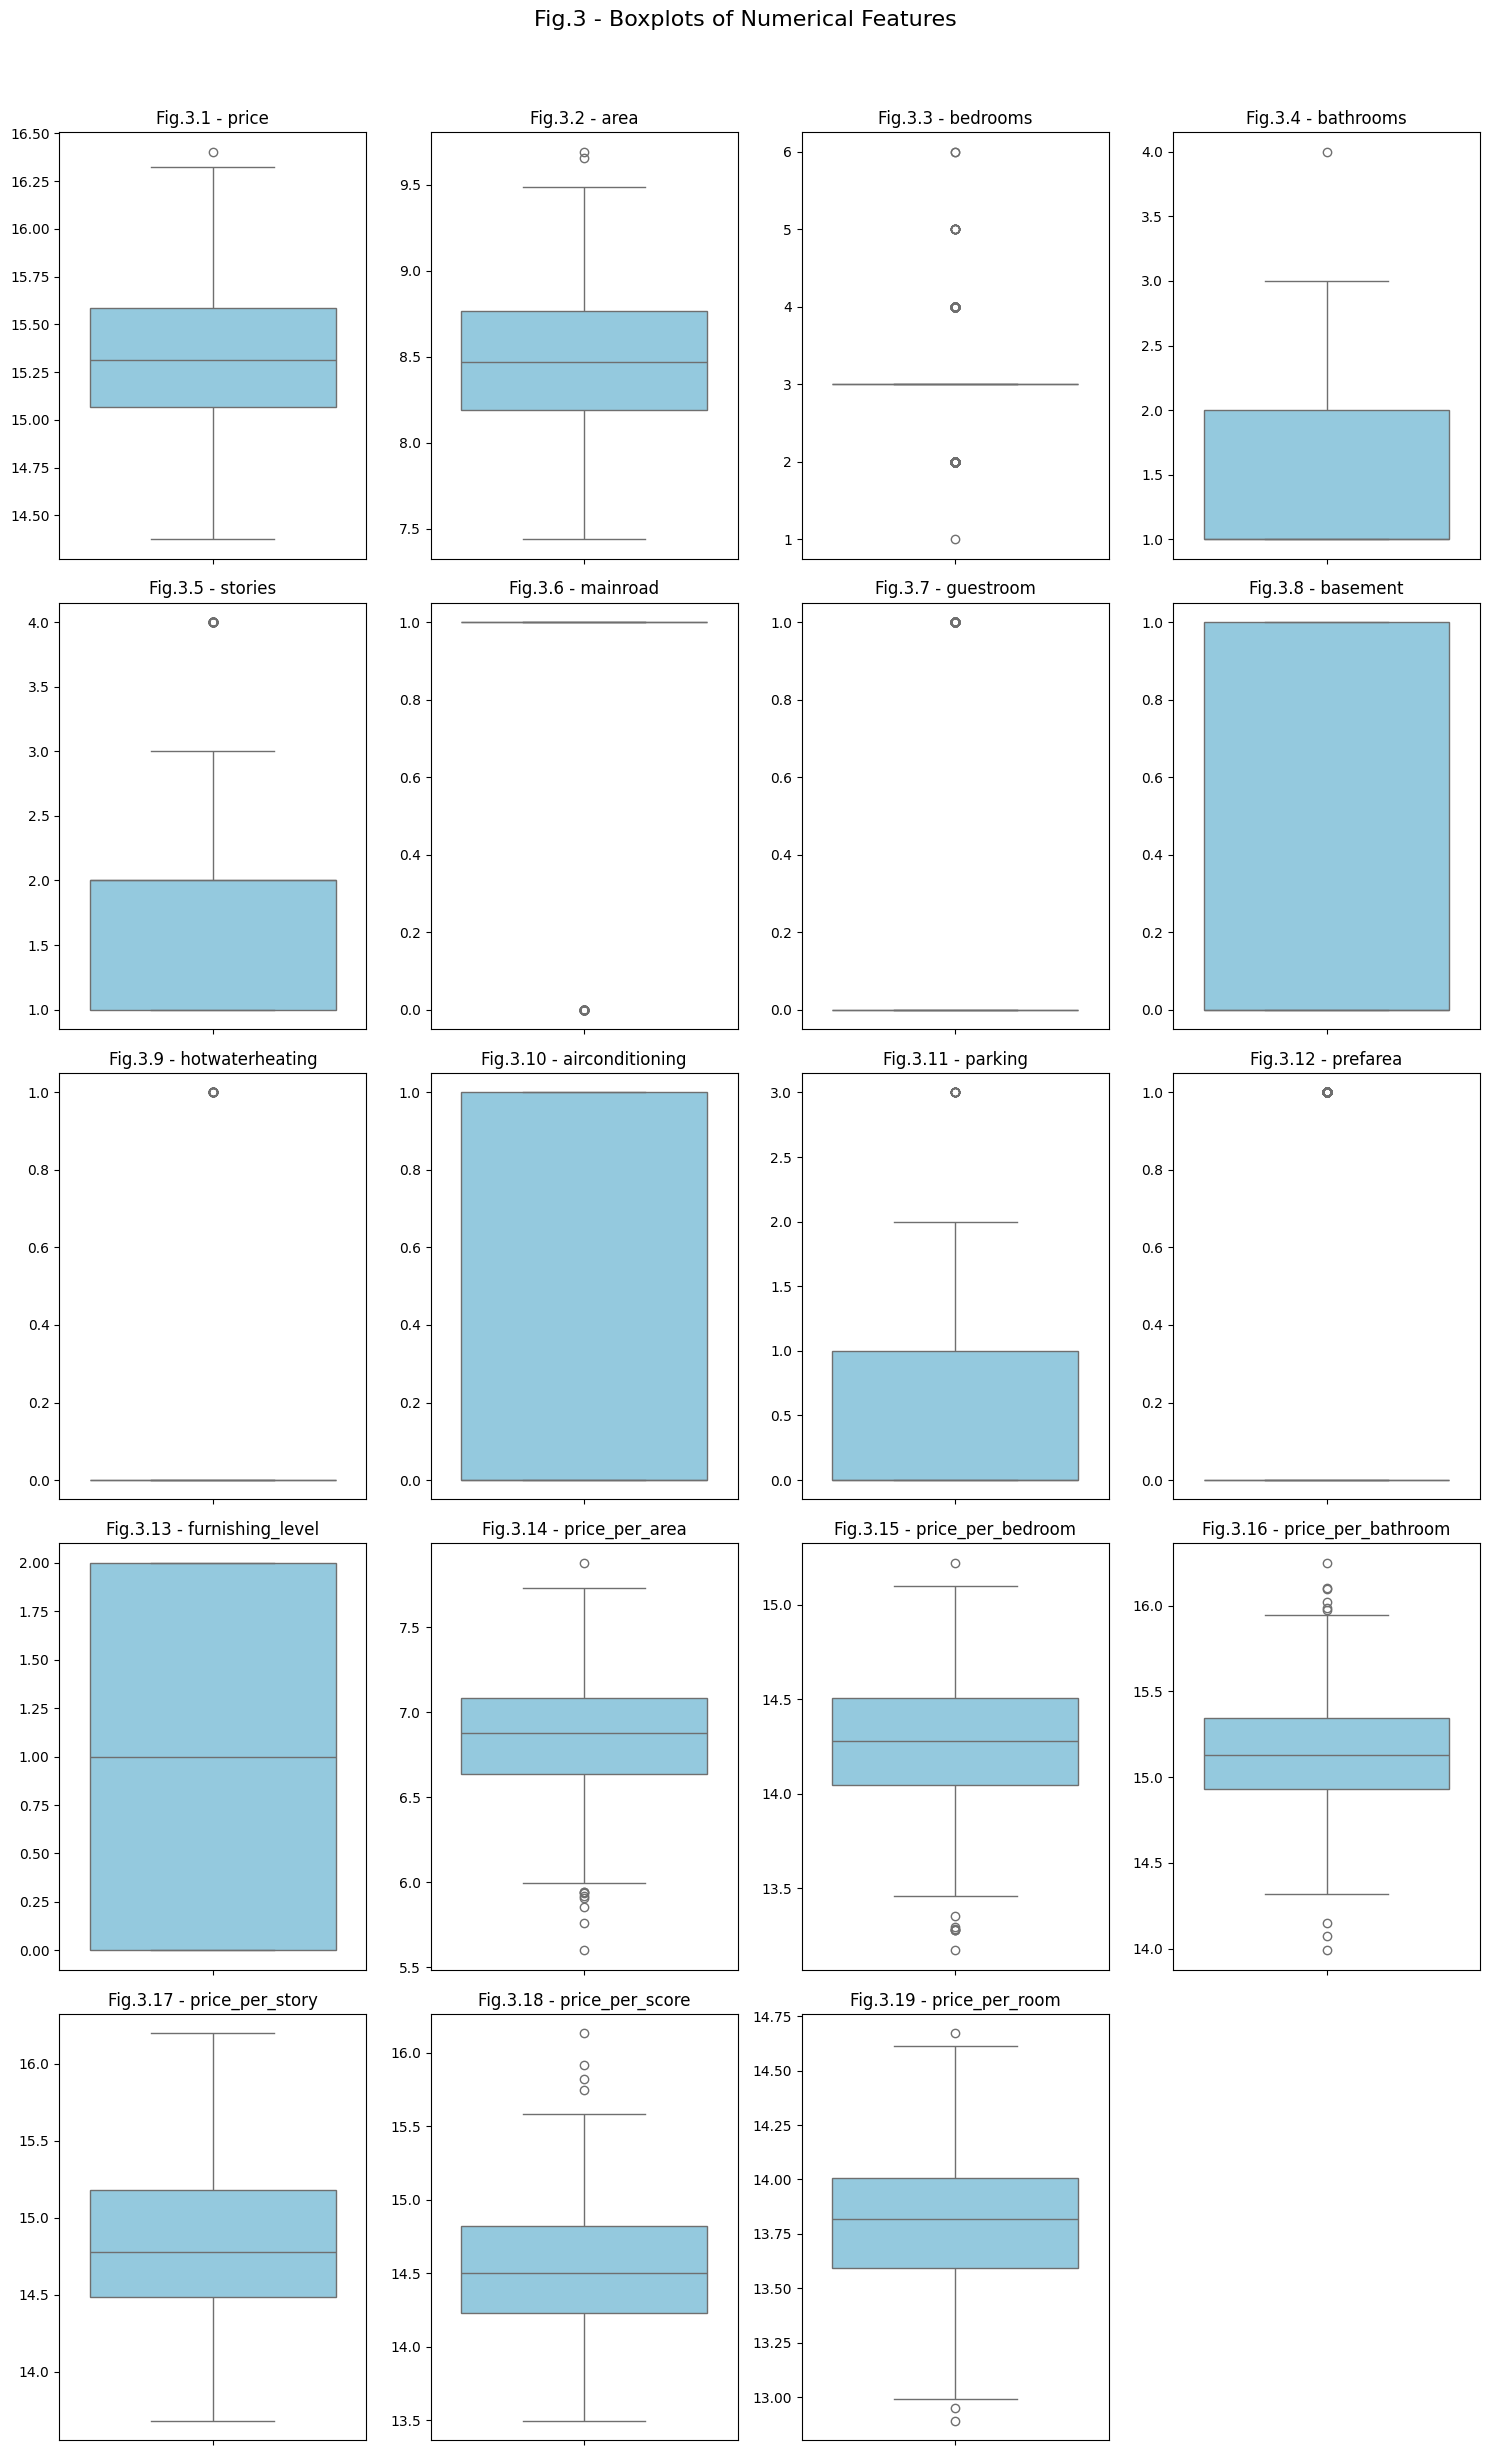

In [18]:
num_cols = 4
title = 'Fig.3 - Boxplots of Numerical Features'
fig_no = 3
boxplot(df_cleaned, num_cols, title, fig_no)

In [24]:
# Create a copy of df
data_outliers_detection = df_cleaned.copy()

# kNN detector
clf_name = 'KNN'
# Set a fixed random seed for reproducibility
np.random.seed(42)
clf = KNN()
clf.fit(data_outliers_detection)

# get the prediction labels and outlier scores of the training data
outliers = clf.labels_  # binary labels (0: inliers, 1: outliers)
outliers_scores = clf.decision_scores_  # raw outlier scores

# it is possible to get the prediction confidence as well
outliers, outliers_confidence = clf.predict(data_outliers_detection, return_confidence=True)  # outlier labels (0 or 1) and confidence in the range of [0,1]

In [25]:
# Create a DataFrame to store the results
results_outliers = data_outliers_detection.copy()  # Start with the original data
results_outliers['Outlier'] = outliers  # Add outlier predictions (0 or 1)
results_outliers['Confidence'] = outliers_confidence  # Add confidence scores

# Display the first few rows of the results DataFrame
results_outliers.head()

price  area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0  16.40  8.91      4.00       2.00     3.00         1          0         0   
1  16.32  9.10      4.00       4.00     4.00         1          0         0   
2  16.32  9.21      3.00       2.00     2.00         1          0         1   
3  16.32  8.92      4.00       2.00     2.00         1          0         1   
4  16.25  8.91      4.00       1.00     2.00         1          1         1   

   hotwaterheating  airconditioning  ...  prefarea  furnishing_level  \
0                0                1  ...         1                 2   
1                0                1  ...         0                 2   
2                0                0  ...         1                 1   
3                0                1  ...         1                 2   
4                0                1  ...         0                 2   

   price_per_area  price_per_bedroom  price_per_bathroom  price_per_story  \
0            7.49              15.02               15.71            15.30   
1            7.22              14.93               14.93            14.93   
2            7.11              15.22               15.63            15.63   
3            7.40              14.93               15.63            15.63   
4            7.34              14.86               16.25            15.56   

   price_per_score  price_per_room  Outlier  Confidence  
0            14.79           14.61        0        0.85  
1            14.93           14.24        1        1.00  
2            15.22           14.53        1        1.00  
3            14.71           14.37        1        1.00  
4            14.86           14.30        0        0.85  

[5 rows x 21 columns]

In [26]:
# Add the outlier predictions to the DataFrame
data_outliers_detection['Outlier'] = outliers

# Count the number of outliers
num_outliers = data_outliers_detection[data_outliers_detection['Outlier'] == 1].shape[0]

# Print the result
print(f"Number of outliers detected: {num_outliers}")

# Filter and display df without outliers
no_outliers_df = data_outliers_detection[data_outliers_detection['Outlier'] == 0]
no_outliers_df = no_outliers_df.drop(columns="Outlier")
print("Data Without Outliers:")
no_outliers_df.head()

Number of outliers detected: 37
Data Without Outliers:


price  area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0  16.40  8.91      4.00       2.00     3.00         1          0         0   
4  16.25  8.91      4.00       1.00     2.00         1          1         1   
6  16.13  9.06      4.00       3.00     4.00         1          0         0   
8  16.11  9.00      4.00       1.00     2.00         1          1         1   
9  16.10  8.66      3.00       2.00     4.00         1          1         0   

   hotwaterheating  airconditioning  parking  prefarea  furnishing_level  \
0                0                1     2.00         1                 2   
4                0                1     2.00         0                 2   
6                0                1     2.00         1                 1   
8                0                1     2.00         1                 2   
9                0                1     1.00         1                 0   

   price_per_area  price_per_bedroom  price_per_bathroom  price_per_story  \
0            7.49              15.02               15.71            15.30   
4            7.34              14.86               16.25            15.56   
6            7.08              14.75               15.03            14.75   
8            7.11              14.72               16.11            15.41   
9            7.44              15.00               15.40            14.71   

   price_per_score  price_per_room  
0            14.79           14.61  
4            14.86           14.30  
6            14.75           14.19  
8            14.50           14.16  
9            15.00           14.31

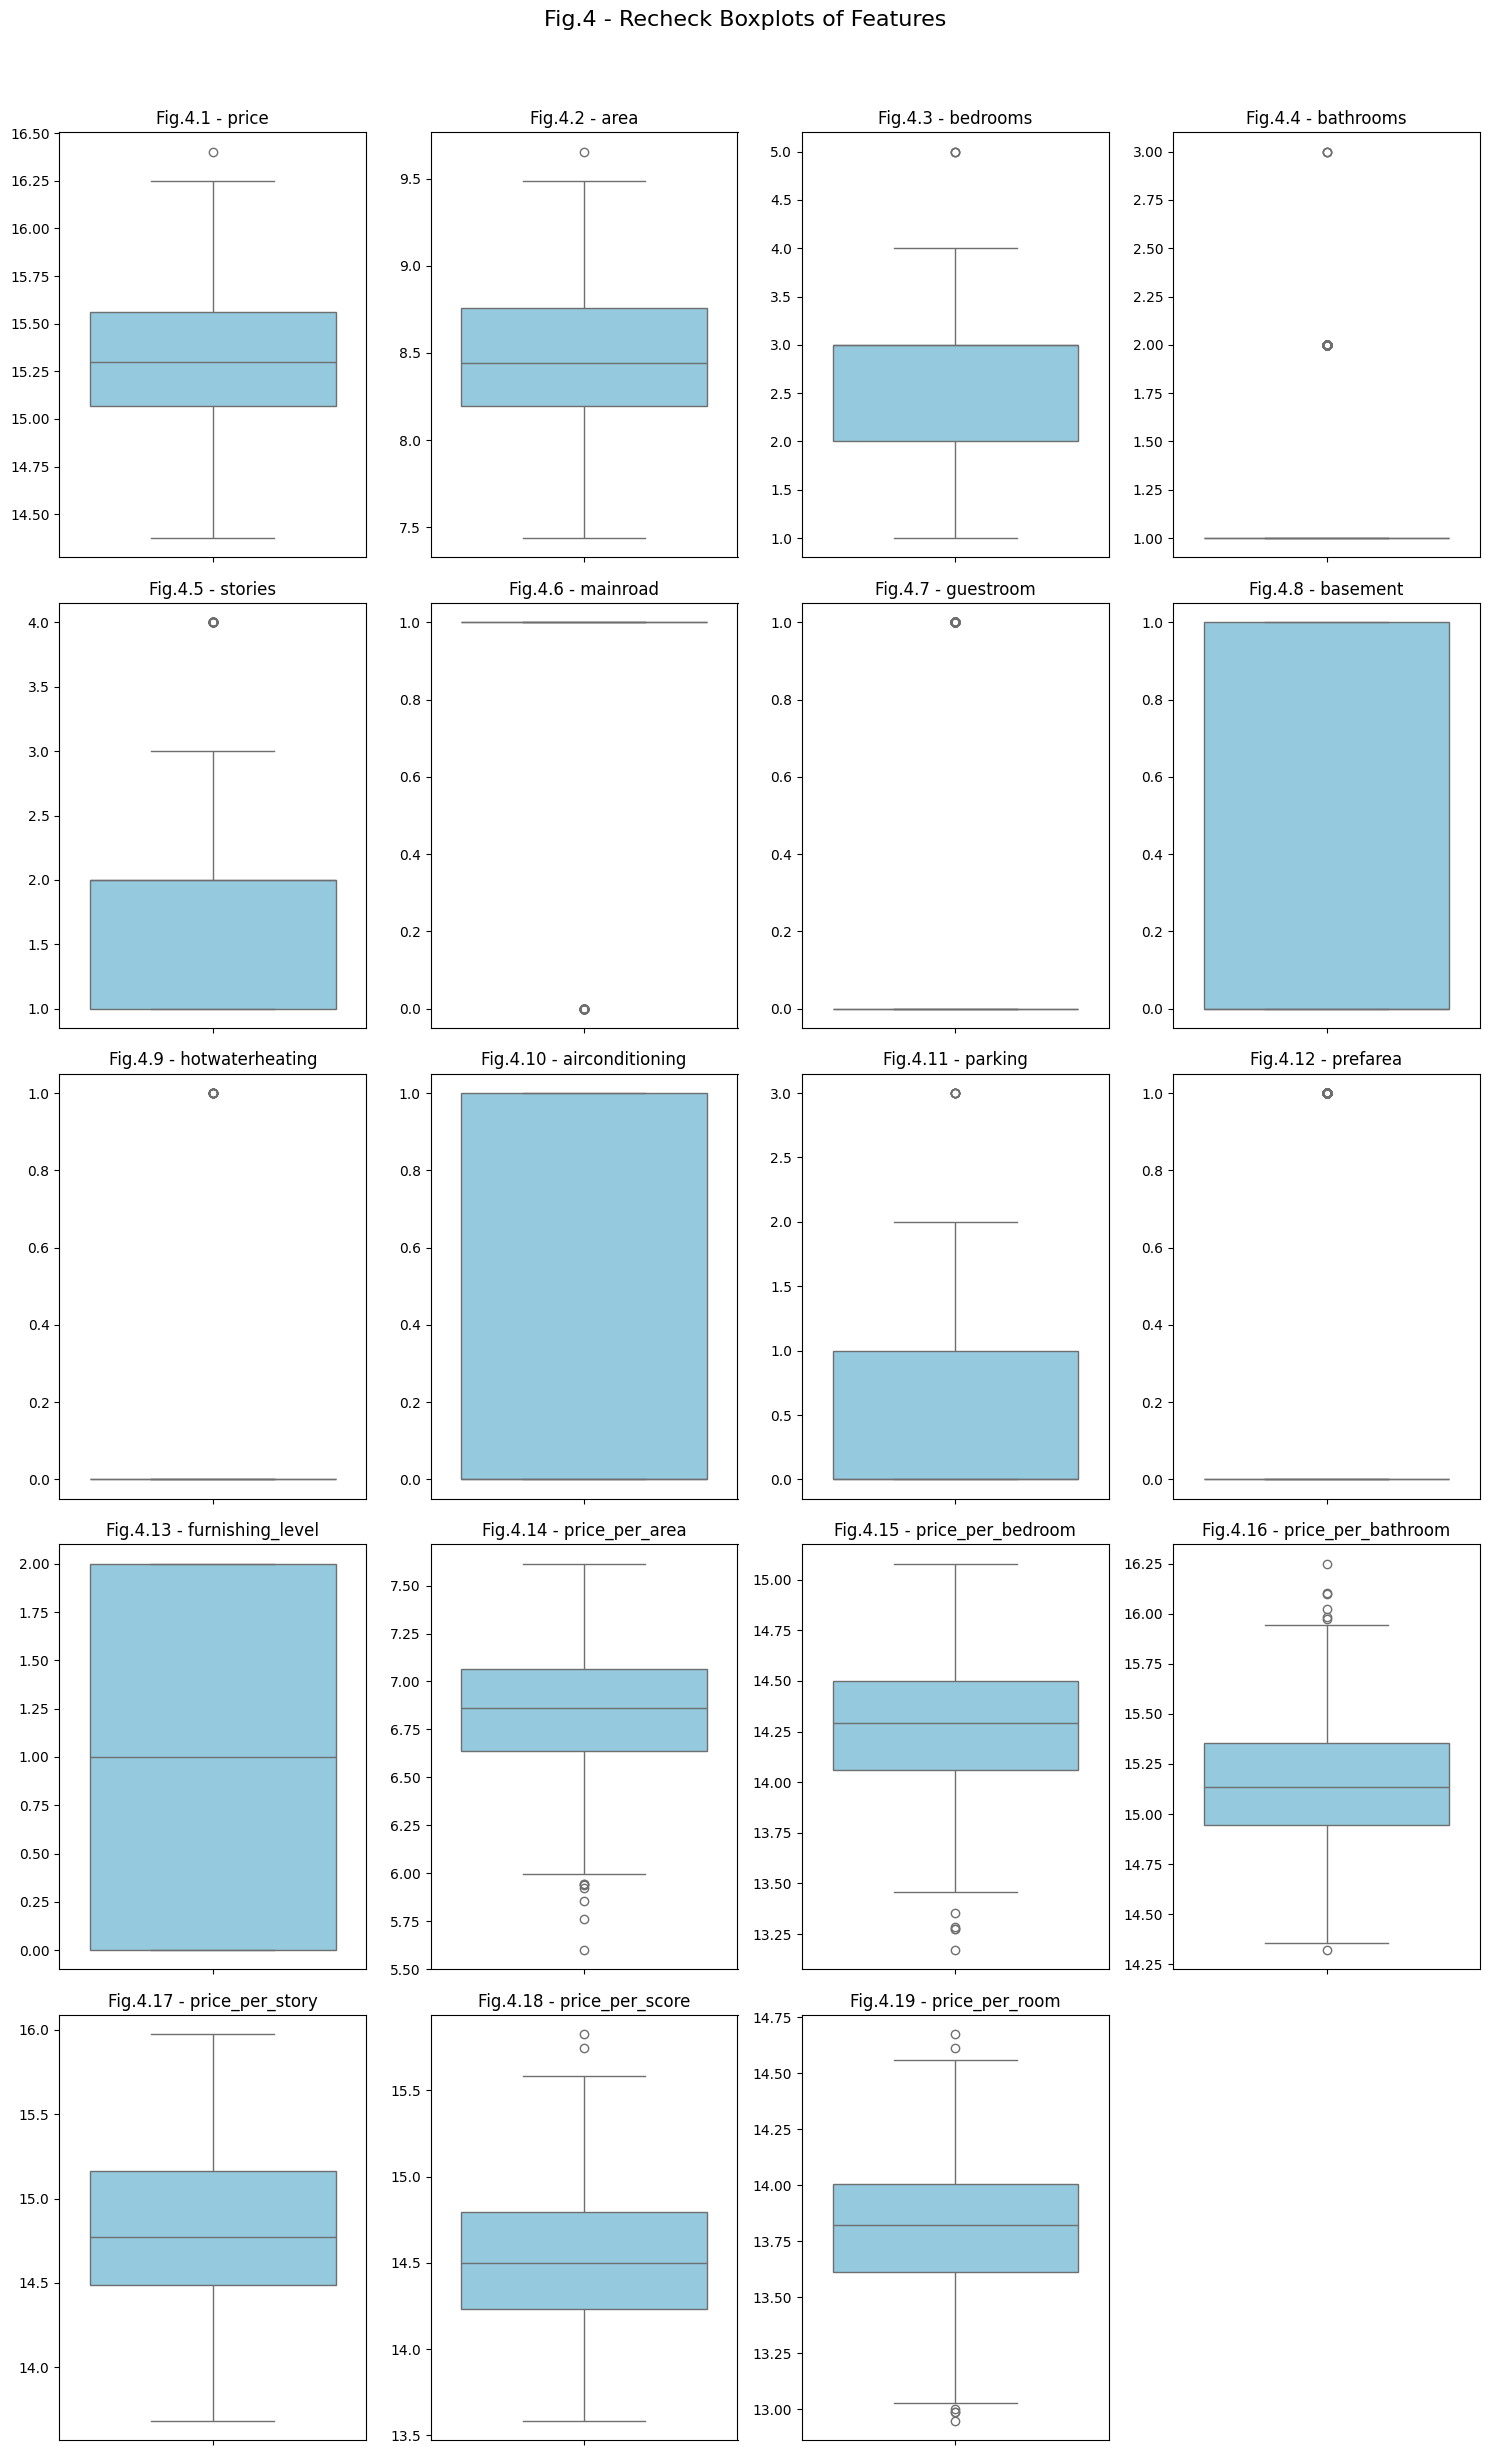

In [27]:
num_cols = 4
title = 'Fig.4 - Recheck Boxplots of Features'
fig_no = 4
boxplot(no_outliers_df, num_cols, title, fig_no)

Fig.5 - Pairplot of Features with Outliers Highlighted


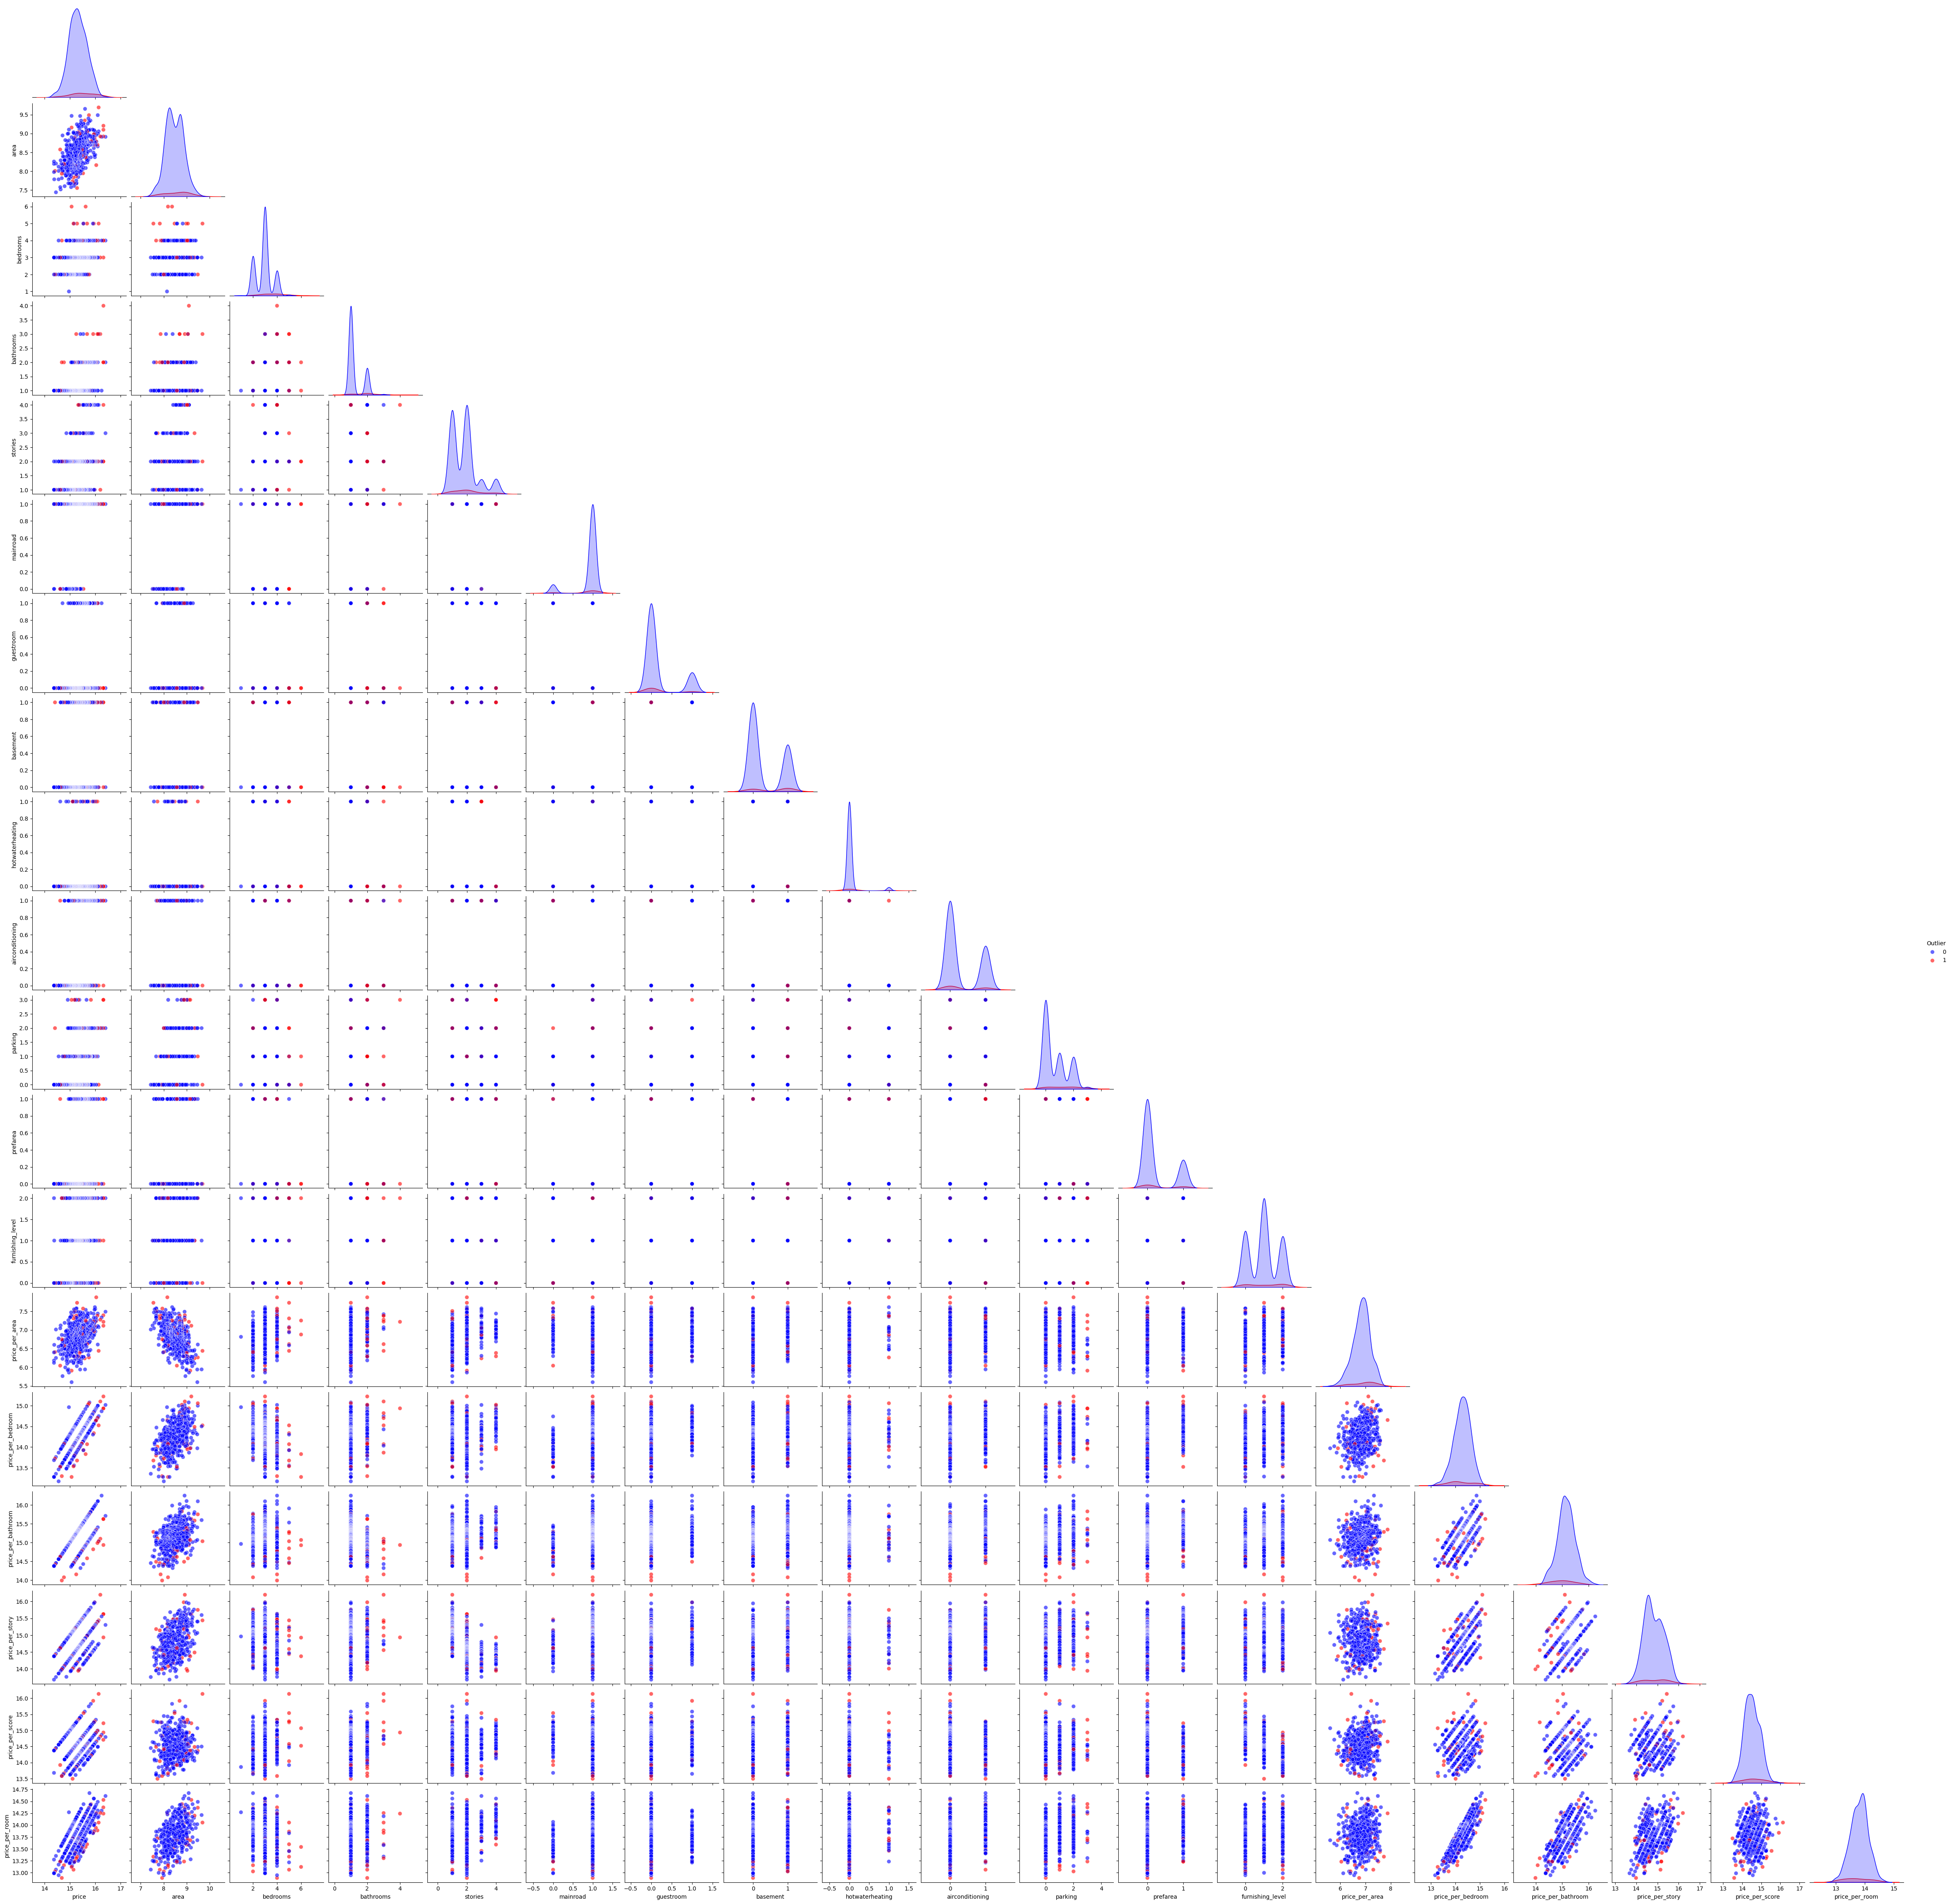

In [28]:
plot_pairplot(data_outliers_detection, hue_col="Outlier", title="Fig.5 - Pairplot of Features with Outliers Highlighted")




## 2.C. Principal Component Analysis


In [31]:
# PCA dataset
pca_data = no_outliers_df.drop(columns=['price'])

# Initialize PCA
pca_data_scaled = preprocessing.scale(pca_data)
pca = PCA(len(pca_data.columns))
pca.fit(pca_data_scaled)

# Result
pr_var = pca.explained_variance_ratio_
cum_pr = np.cumsum(pca.explained_variance_ratio_)
ind = ['Proportion of variance','Cumulative Proportion of variance']

# Number of principal components you have
num_components = len(pca_data.columns)

# Generate column names dynamically for the number of components
col = [f'PC{i}' for i in range(num_components)]

pd.DataFrame(np.vstack((pr_var, cum_pr)), ind, columns = col)

PC0  PC1  PC2  PC3  PC4  PC5  PC6  PC7  \
Proportion of variance            0.21 0.13 0.10 0.09 0.09 0.07 0.06 0.06   
Cumulative Proportion of variance 0.21 0.35 0.45 0.54 0.62 0.69 0.75 0.81   

                                   PC8  PC9  PC10  PC11  PC12  PC13  PC14  \
Proportion of variance            0.05 0.04  0.04  0.03  0.03  0.00  0.00   
Cumulative Proportion of variance 0.85 0.90  0.94  0.97  1.00  1.00  1.00   

                                   PC15  PC16  PC17  
Proportion of variance             0.00  0.00  0.00  
Cumulative Proportion of variance  1.00  1.00  1.00

In [32]:
# Coefficients (Loadings) of Principal Components
pc_res = pd.DataFrame(pca.components_.T, index=list(pca_data.columns),columns=col)

# Find the highest absolute coefficient for each feature
highest_coefficients = pc_res.abs().idxmax(axis=0)
highest_values = pc_res.max(axis=0)

# Display the results
result = pd.DataFrame({
    'Highest_PC': highest_coefficients,
    'Value': highest_values
})
result

Highest_PC  Value
PC0    price_per_bedroom   0.44
PC1              stories   0.56
PC2             basement   0.49
PC3                 area   0.50
PC4      price_per_score   0.53
PC5            bathrooms   0.57
PC6      hotwaterheating   0.70
PC7             mainroad   0.70
PC8              parking   0.51
PC9             prefarea   0.66
PC10     airconditioning   0.73
PC11             parking   0.56
PC12            basement   0.66
PC13     price_per_score   0.61
PC14     price_per_story   0.65
PC15  price_per_bathroom   0.53
PC16   price_per_bedroom   0.72
PC17                area   0.62

In [34]:
# Select the top PC
top_10_unique_highest_pc = result['Highest_PC'].drop_duplicates().head(10)
print(top_10_unique_highest_pc.values)

['price_per_bedroom' 'stories' 'basement' 'area' 'price_per_score'
 'bathrooms' 'hotwaterheating' 'mainroad' 'parking' 'prefarea']


# **3. OLS**

In [36]:
# Define independent variables (X) and dependent variable (y)
X = no_outliers_df[top_10_unique_highest_pc]
y = no_outliers_df['price']

# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model_OLS = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Get residuals and fitted values
residuals = model_OLS.resid
fitted_values = model_OLS.fittedvalues

# Print model summary
print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     166.5
Date:                Mon, 24 Mar 2025   Prob (F-statistic):          7.11e-131
Time:                        05:40:43   Log-Likelihood:                 198.33
No. Observations:                 384   AIC:                            -374.7
Df Residuals:                     373   BIC:                            -331.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                15.3132      0.00

- The model is a good fit for predicting price, with 81.7% of the variance explained.

- Key drivers of price include `price_per_bedroom, stories, basement, area, bathrooms, parking, and prefarea`.

- Variables like `hotwaterheating, mainroad` do not significantly impact price.


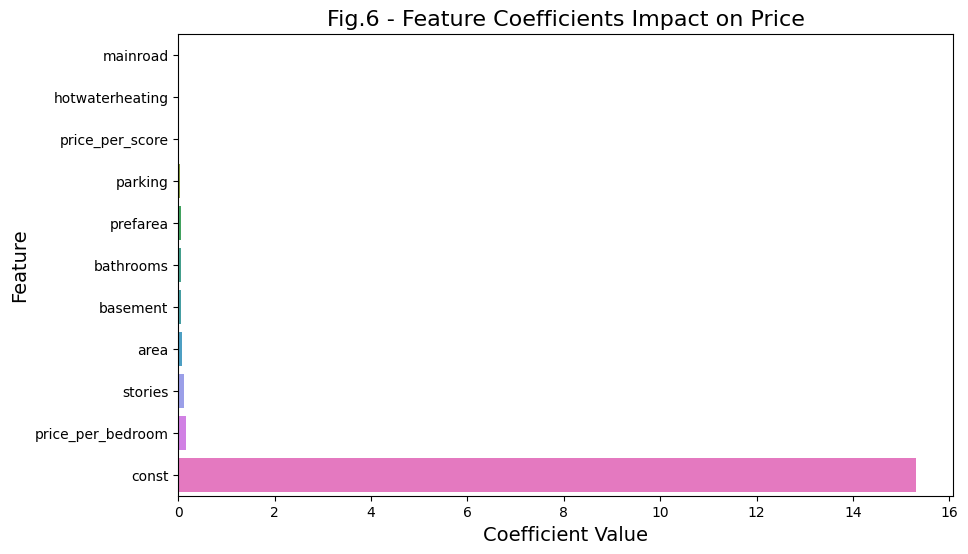

In [47]:
# Extract coefficients
coefficients = model_OLS.params
# Sort the data by coefficient values
coefficients = coefficients.sort_values(ascending=True)
coefficients = coefficients.reset_index()
coefficients.rename(columns={'index': 'Feature', 0: 'Coefficient'}, inplace=True)

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, hue="Feature", legend=False)

# Add labels and title
plt.title('Fig.6 - Feature Coefficients Impact on Price', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Display the plot
plt.show()

In [39]:
# Evaluate model on test data
y_pred = model_OLS.predict(sm.add_constant(X_test))

# Compute evaluation metrics
metrics = {
    "R² Score": r2_score(y_test, y_pred),
    "RMSE": root_mean_squared_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
}

# Convert metrics to DataFrame
df_metrics = pd.DataFrame([metrics],index=['OLS'])

# Second model performance
y_pred = model_OLS.predict(sm.add_constant(X_test))
df_metrics.loc['OLS'] = [r2_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)),mean_squared_error(y_test, y_pred)]

np.round(df_metrics,2)

R² Score  RMSE  MSE
OLS      0.82  0.16 0.03

## **4. Detect violations of linear regression assumptions**







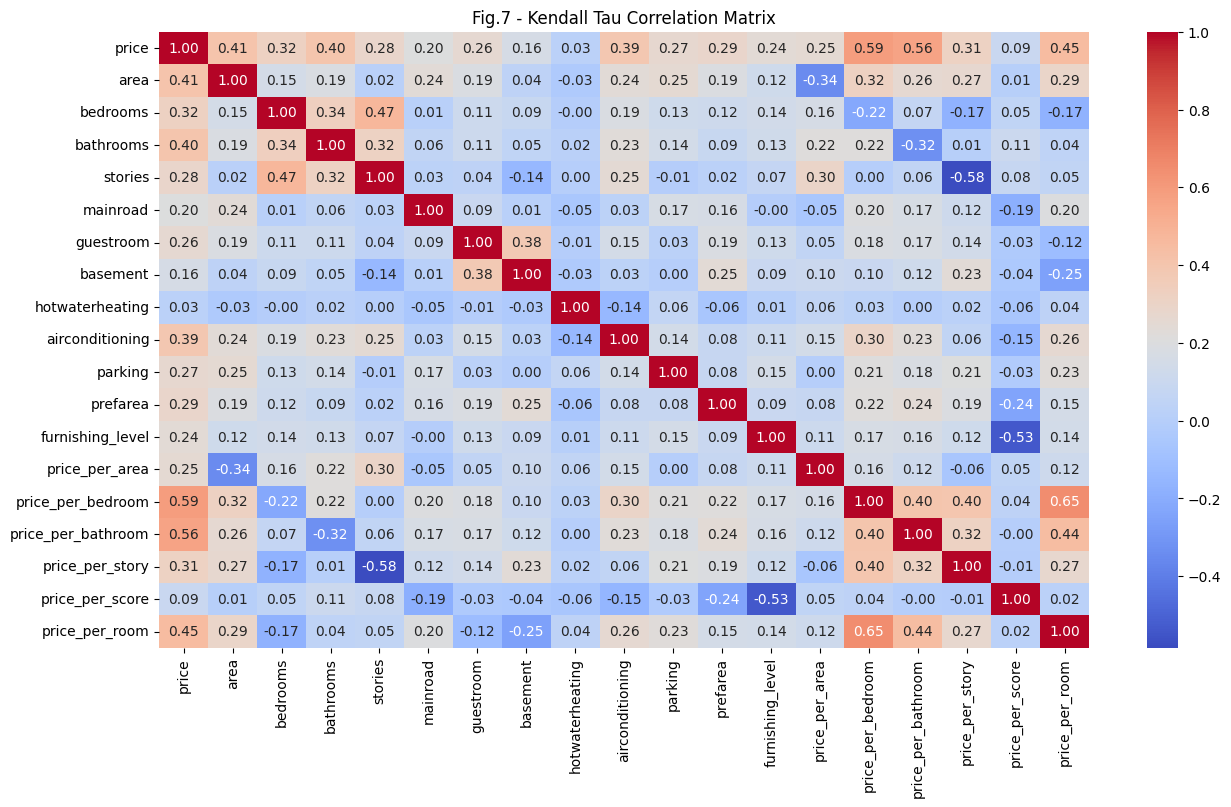

In [48]:
# 2. Independence: Calculate Kendall Tau correlation
corr_matrix = no_outliers_df.corr(method='kendall')

# Plot the correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Fig.7 - Kendall Tau Correlation Matrix')
plt.show()

- As shown in Fig. 7, the dataset doesn’t show any extremely strong correlations between variables, which is a good sign for avoiding multicollinearity issues.

In [41]:
# 2. Independence: Variance Inflation Factor (VIF)
# Extract independent variables from the OLS model
variables = model_OLS.model.exog

# Compute VIF for each variable
vif_data = pd.DataFrame({
    "Feature": ['const', 'price_per_bedroom', 'stories', 'basement', 'area',
                'price_per_score', 'bathrooms', 'hotwaterheating', 'mainroad',
                'parking', 'prefarea'],
    "VIF": [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
})

# Display VIF values
print(vif_data)

              Feature  VIF
0               const 1.00
1   price_per_bedroom 1.42
2             stories 1.26
3            basement 1.15
4                area 1.40
5     price_per_score 1.27
6           bathrooms 1.28
7     hotwaterheating 1.04
8            mainroad 1.25
9             parking 1.14
10           prefarea 1.28


- As all VIF values are below 5, the result indicates that there is no multicollinearity among variables.

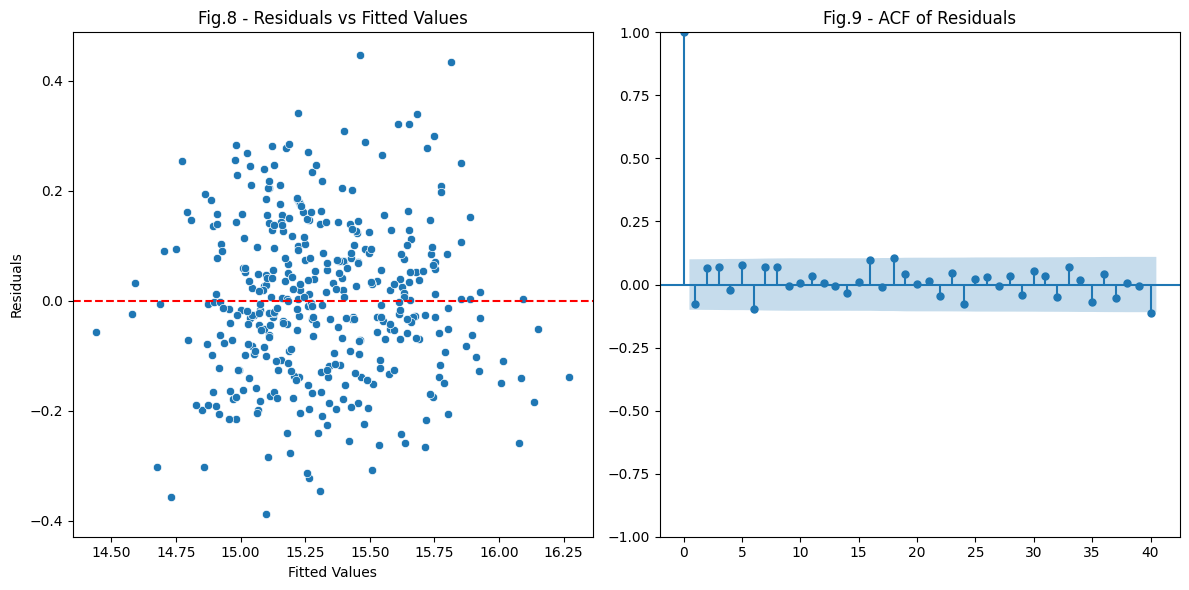

In [49]:
# 3. Homoscedasticity
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fig.8 - Residuals vs Fitted Values')

# 4. No Autocorrelation - Second subplot: ACF of residuals
plt.subplot(1, 2, 2)
plot_acf(residuals, lags=40, ax=plt.gca())  # Adjust lags as needed
plt.title('Fig.9 - ACF of Residuals')

plt.tight_layout()
plt.show()

From Figure 8, no “cone” shape between residuals and fitted value, which is a sign of heteroscedasticity, can be observed. To further confirm this conclusion, we perform a Breusch-Pagan test below.

In [43]:
# Breusch-Pagan Test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = het_breuschpagan(model_OLS.resid, model_OLS.model.exog)
pd.DataFrame(test, index=name, columns=[""])

Lagrange multiplier statistic 7.66
p-value                       0.66
f-value                       0.76
f p-value                     0.67

- The test confirms no presence of **heteroskedasticity** since the **p-value is higher than 0.05**.

- Furthermore, Figure 9 confirms the Durbin-Watson statistic from the OLS model summary that **residuals are not significantly autocorrelated**.

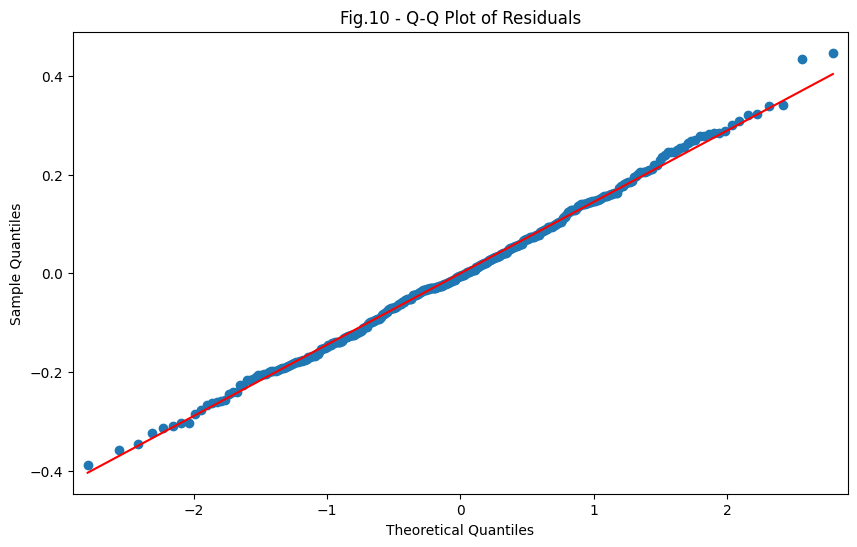

In [51]:
# 5. Q-Q Plot
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='s', ax=plt.gca())  # Ensure it plots within the figure
plt.title('Fig.10 - Q-Q Plot of Residuals')
plt.show()

Figure 10 shows that the residuals closely follow the diagonal line in the Q-Q plot, suggesting that they are approximately normally distributed. This is further supported by the Omnibus test (p = 0.573) and the Jarque-Bera test (p = 0.557), both of which fail to reject the null hypothesis of normality. Additionally, the skewness (0.127) and kurtosis (2.907) values are close to those expected for a normal distribution, further reinforcing the assumption of normality.

In [46]:
# Shapiro-Wilk Test for Normality
shapiro_test = shapiro(residuals)
print("\nShapiro-Wilk Test for Normality:")
print(f"Test Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")


Shapiro-Wilk Test for Normality:
Test Statistic: 0.9971953164920115, p-value: 0.7583310147193942


- **Null Hypothesis (H_0):**
The residuals come from a normal distribution.

- **Alternative Hypothesis (H_1):**
The residuals do not follow a normal distribution.

- p-value: 0.7583 (greater than 0.05). Since the p-value is high (> 0.05), we fail to reject the null hypothesis, meaning there is no strong evidence against normality.